<a href="https://colab.research.google.com/github/LuchoValr/The-effect/blob/main/Cap14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Matching multivariado con Mahalanobis

In [1]:
!pip install causalinference
!pip install causaldata
import pandas as pd
import numpy as np
from causalinference.causal import CausalModel
from causaldata import black_politicians

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
br = black_politicians.load_pandas (). data
br.head()

,leg_black,treat_out,responded,totalpop,medianhhincom,black_medianhh,white_medianhh,blackpercent,statessquireindex,nonblacknonwhite,urbanpercent,leg_senator,leg_democrat,south
0,0,0,0,1.5873,5.0625,2.6814,2.6586,0.007119,0.227,0,0.695601,0,0,0
1,0,0,1,1.6218,4.9713,2.7126,2.6619,0.005796,0.227,0,0.618073,0,0,0
2,0,0,1,1.6710,6.9646,2.3087,2.9973,0.012029,0.227,0,0.824331,0,0,0
3,0,0,1,1.6122,4.1811,2.4668,2.4887,0.004280,0.227,1,0.000000,0,0,0
4,0,1,1,1.5622,3.1152,2.1490,2.0597,0.008258,0.227,1,0.000000,0,1,0


In [3]:
# Get our outcome , treatment , and matching variables
# We need these as numpy arrays
Y = br['responded']. to_numpy ()
D = br['leg_black']. to_numpy ()
X = br[['medianhhincom', 'blackpercent', 'leg_democrat']]. to_numpy ()

In [4]:
# Set up our model
M = CausalModel(Y, D, X)

In [5]:
# Fit, using Mahalanobis distance
M.est_via_matching(weights = 'maha', matches = 1)

In [6]:
print(M.estimates)
# Note it automatically calcultes average treatments on average , on treated , and on untreated/control (ATC)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.050      0.175     -0.285      0.776     -0.392      0.293
           ATC     -0.052      0.186     -0.282      0.778     -0.418      0.313
           ATT     -0.012      0.099     -0.120      0.904     -0.206      0.182



In [7]:
#balance table
print(M.summary_stats)


Summary Statistics

                      Controls (N_c=5229)         Treated (N_t=364)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.425        0.494        0.393        0.489       -0.032

                      Controls (N_c=5229)         Treated (N_t=364)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0        4.435        1.398        3.330        1.139       -0.867
             X1        0.063        0.096        0.517        0.202        2.869
             X2        0.501        0.500        0.978        0.147        1.295



#Coarsened exact matching

In [8]:
import statsmodels.formula.api as sm

In [9]:
br = black_politicians.load_pandas (). data

In [10]:
# Create bins for our continuous matching variables
# cut creates evenly spaced bins
# while qcut cuts based on quantiles
br['inc_bins'] = pd.qcut(br['medianhhincom'], 6)
br['bp_bins'] = pd.qcut(br['blackpercent'], 6)

In [11]:
# Count how many treated and control observations
# are in each bin
treated = br.loc[br['leg_black'] == 1].groupby (['inc_bins','bp_bins','leg_democrat']).size (). to_frame('treated')
control = br.loc[br['leg_black'] == 0].groupby (['inc_bins','bp_bins','leg_democrat']).size (). to_frame('control')

In [12]:
# Merge those counts back in
br = br.join(treated , on = ['inc_bins','bp_bins','leg_democrat'])
br = br.join(control , on = ['inc_bins','bp_bins','leg_democrat'])

In [13]:
# For treated obs, weight is 1 if there are any control matches
br['weight'] = 0
br.loc[(br['leg_black'] == 1) & (br['control'] > 0), 'weight'] = 1
# For control obs, weight depends on total number of treated and control
# obs that found matches
totalcontrols = sum(br.loc[br['leg_black']==0]['treated'] > 0)
totaltreated = sum(br.loc[br['leg_black']==1]['control'] > 0)
# Then, control weights are treated/control in the bin,
# times control/treated overall
br['controlweights'] = (br['treated']/br['control'])*( totalcontrols/totaltreated)
br.loc[(br['leg_black'] == 0), 'weight'] = br['controlweights']

In [14]:
# Now, use the weights to estimate the effect
m = sm.wls(formula = 'responded ~ leg_black ',weights = br['weight'],data = br).fit()
m.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              responded   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.373
Date:                Wed, 07 Jun 2023   Prob (F-statistic):             0.0365
Time:                        00:06:50   Log-Likelihood:                   -inf
No. Observations:                5593   AIC:                               inf
Df Residuals:                    5591   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4302      0.007     59.538      0.000       0.416       0.444
leg_black     -0.0373      0.018     -2.091      0.037      -0.072      -0.002
==============================================================================
Omnibus:                     1327.802   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16206.374
Skew:                           0.785   Prob(JB):                         0.00
Kurtosis:                      11.190   Cond. No.                         2.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#Entropy balance en Stata

In [15]:
#* STATA CODE
# * If necessary: ssc install ebalance
#causaldata black_politicians.dta , use clear download

#* Specify the treatment and matching variables
#* And then in targets() specify which moments to match
#* 1 for means , 2 for variances , 3 for skew
#* Let 's do means and variances for our continuous variables
#* and just means for our binary matching variable (leg_democrat)
#* and store the resulting weights in wt
#ebalance leg_black medianhhincom blackpercent leg_democrat , ///
#targets(2 2 1) g(wt)

#* Use pweight = wt to adjust estimates
#reg responded leg_black [pw = wt]

#Propensity score

In [16]:
br = black_politicians.load_pandas (). data

In [17]:
# Get our outcome , treatment , and matching variables as numpy arrays
Y = br['responded']. to_numpy ()
D = br['leg_black']. to_numpy ()
X = br[['medianhhincom', 'blackpercent', 'leg_democrat']]. to_numpy ()

In [18]:
# Set up our model
M = CausalModel(Y, D, X)

In [19]:
# Estimate the propensity score using logit
M.est_propensity ()

In [20]:
# Trim the score with improved algorithm trim_s to improve balance
M.trim_s()

In [21]:
# If we want to use the scores elsewhere , export them
# (we could have also done this with sm.Logit)
br['ps'] = M.propensity['fitted']

In [22]:
# We can estimate the effect directly (note this uses "doubly robust" methods
# as will be later described , which is why it doesn't match the sm.wls result)
M.est_via_weighting ()

/usr/local/lib/python3.10/dist-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [23]:
print(M.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.047      0.080      0.588      0.557     -0.109      0.203



In [24]:
# Or we can do our own weighting
br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))

In [25]:
# Now, use the weights to estimate the effect (this will produce
# incorrect standard errors unless we bootstrap the whole process ,
# as in the doubly robust section later , or the Simulation chapter)
m = sm.wls(formula = 'responded ~ leg_black ',weights = br['ipw'],data = br).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              responded   R-squared:                       0.022
Model:                            WLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     128.6
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           1.75e-29
Time:                        00:06:51   Log-Likelihood:                -5768.6
No. Observations:                5593   AIC:                         1.154e+04
Df Residuals:                    5591   BIC:                         1.155e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4100      0.009     43.596      0.000       0.392       0.428
leg_black      0.1499      0.013     11.340      0.000       0.124       0.176
==============================================================================
Omnibus:                     2184.371   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2062976.257
Skew:                           0.078   Prob(JB):                         0.00
Kurtosis:                      97.087   Cond. No.                         2.63
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#Balance table

In [26]:
#Para checkear balance
#En python se crea una variable M = CausalModel() del paquete causalinference y luego corremos print(M.summary_stats)

#Overlaid density

In [27]:
#br = black_politicians.load_pandas (). data

In [28]:
import seaborn as sns

[]

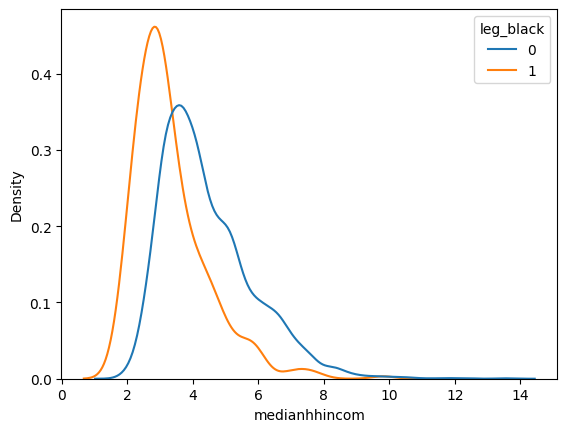

In [29]:
# Overlaid treatment/control density in raw data
fig1 = sns.kdeplot(data = br,x = 'medianhhincom',hue = 'leg_black',common_norm = False)
fig1.plot()

In [30]:
# Start the new plot
fig1.get_figure ().clf()

[]

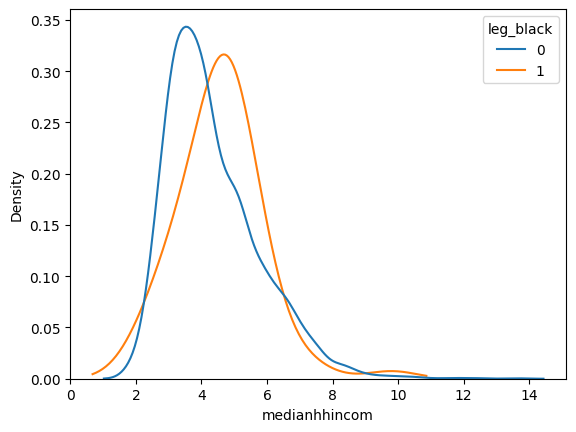

In [31]:
# Add weights from any weighting method to check post-matching density
# Here we have the ipw variable from our propensity score matching
# in previous code blocks (make sure you run those first!)
fig2 = sns.kdeplot(data = br, x = 'medianhhincom', hue = 'leg_black', common_norm = False , weights = 'ipw')
fig2.plot()

#Matching con Regresion

In [32]:
br = black_politicians.load_pandas (). data

In [33]:
# This copies the CEM code from the CEM section
# See that section's code for comments and notes
br['inc_bins'] = pd.qcut(br['medianhhincom'], 6)
br['bp_bins'] = pd.qcut(br['blackpercent'], 6)
treated = br.loc[br['leg_black'] == 1].groupby (['inc_bins','bp_bins','leg_democrat']).size (). to_frame('treated')
control = br.loc[br['leg_black'] == 0].groupby (['inc_bins','bp_bins','leg_democrat']).size (). to_frame('control')
br = br.join(treated , on = ['inc_bins','bp_bins','leg_democrat'])
br = br.join(control , on = ['inc_bins','bp_bins','leg_democrat'])

In [34]:
br['weight'] = 0
br.loc[(br['leg_black'] == 1) & (br['control'] > 0), 'weight'] = 1

totalcontrols = sum(br.loc[br['leg_black']==0]['treated'] > 0)
totaltreated = sum(br.loc[br['leg_black']==1]['control'] > 0)

br['controlweights'] = (br['treated']/br['control'])*( totalcontrols/totaltreated)
br.loc[(br['leg_black'] == 0), 'weight'] = br['controlweights']

In [52]:
# Now, use the weights to estimate the effect
m = sm.wls(formula = '''responded ~ leg_black*treat_out + nonblacknonwhite + black_medianhh + white_medianhh + statessquireindex + totalpop + urbanpercent''',
           weights = br['weight'],data = br).fit()

In [53]:
m.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              responded   R-squared:                       0.140
Model:                            WLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     100.6
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          6.99e-175
Time:                        00:12:03   Log-Likelihood:                   -inf
No. Observations:                5593   AIC:                               inf
Df Residuals:                    5583   BIC:                               inf
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3741      0.024     15.482      0.000       0.327       0.421
leg_black              -0.1793      0.024     -7.520      0.000      -0.226      -0.133
treat_out              -0.3420      0.014    -25.298      0.000      -0.368      -0.315
leg_black:treat_out     0.1943      0.033      5.851      0.000       0.129       0.259
nonblacknonwhite       -0.1127      0.029     -3.854      0.000      -0.170      -0.055
black_medianhh          0.1060      0.022      4.886      0.000       0.063       0.149
white_medianhh         -0.0070      0.014     -0.488      0.626      -0.035       0.021
statessquireindex       0.3432      0.083      4.127      0.000       0.180       0.506
totalpop                0.0031      0.001      3.216      0.001       0.001       0.005
urbanpercent            0.0428      0.025      1.683      0.092      -0.007       0.093
==============================================================================
Omnibus:                     1525.720   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42721.322
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                      16.467   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#Doubly robust

In [54]:
br = black_politicians.load_pandas (). data

In [57]:
# As mentioned , est_via_weighting from causalinfernece already does
# doubly robust estimation but it's a different kind!
# Let's do Wooldridge here.
def ipwra(br):
  # Estimate propensity
  m = sm.logit('leg_black ~ medianhhincom + blackpercent + leg_democrat ',
               data = br)
  # Get fitted values and turn them into probabilities
  m = m.fit(). fittedvalues
  br['ps'] = np.exp(m)/(1+np.exp(m))
  # Trim observations outside of treated range
  minrange = np.min(br.loc[br['leg_black']==1, 'ps'])
  maxrange = np.max(br.loc[br['leg_black']==1, 'ps'])
  br = br.loc[(br['ps'] >= minrange) & (br['ps'] <= maxrange )]
  # Get inverse probability score
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
  # Regress treated and nontreated separately ,
  # then predict for whole sample
  mtreat = sm.wls('''responded ~ medianhhincom + blackpercent + leg_democrat''',
                  weights = br.loc[br['leg_black'] == 1, 'ipw'], data = br.loc[br['leg_black'] == 1])
  mcontrol = sm.ols('''responded ~ medianhhincom + blackpercent + leg_democrat''',
                    weights = br.loc[br['leg_black'] == 0, 'ipw'], data = br.loc[br['leg_black'] == 0])
  treat_predict = mtreat.fit(). predict(exog = br)
  con_predict = mcontrol.fit(). predict(exog = br)

  # Compare means
  diff = np.mean(treat_predict) - np.mean(con_predict)
  return diff

  # And a wrapper function to bootstrap
def ipwra_b(br):
  n = br.shape [0]
  br = br.iloc[np.random.randint(n, size=n)]
  diff = ipwra(br)
  return diff
# Run once on the original data to get our estimate         
est = ipwra(br)

# And then a bunch of times to get the sampling distribution
dist = [ipwra_b(br) for i in range(0 ,2000)]

# Our estimate
est
# and its standard error
np.std(dist)

Optimization terminated successfully.
         Current function value: 0.089701
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.087810
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.096464
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.082695
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.083630
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.080833
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.087801
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.098976
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.097813
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096875
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085159
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086514
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090012
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.094391
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087211
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079337
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086009
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091088
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089806
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.083979
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.093809
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087090
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082696
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.094076
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095904
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089429
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086048
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.095935
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.081030
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091823
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088440
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.087985
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092742
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083106
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090040
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.103440
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092026
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089998
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092888
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084601
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079630
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084398
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086259
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102995
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085974
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092784
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.085839
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095176
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091709
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.096150
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090346
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092050
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.093376
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088071
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100674
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.083211
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094768
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096006
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.085313
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.096731
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099088
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.096107
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082808
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085357
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.091446
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092849
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094385
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085663
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086341
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086543
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095766
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094229
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097198
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088456
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094874
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090941
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089053
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091519
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101291
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092771
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.102079
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.080977
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092303
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082975
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087675
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095990
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087420
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092635
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095889
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096512
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083207
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084621
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089395
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076596
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082641
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088062
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086957
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079871
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.086363
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086622
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094352
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090474
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084301
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091711
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081841
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083740
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.099246
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103231
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082554
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.076787
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.101819
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082180
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082909
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083990
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096199
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087086
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087254
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092024
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081130
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075120
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093455
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093517
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087799
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095404
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094960
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088888
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090049
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082220
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089356
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083117
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091443
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098348
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090414
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090535
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086483
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079494
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097084
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085875
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091626
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091043
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091480
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094643
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087853
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095214
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089989
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089586
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088764
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087309
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092819
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.079503
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085276
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088177
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086277
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095914
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085631
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090425
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085853
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085354
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096474
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085566
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081547
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093522
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087677
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092552
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089971
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092054
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.089592
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103458
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085103
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090251
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091624
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087677
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097705
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096634
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093410
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086635
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080736
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088485
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097782
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085060
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096097
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078071
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090390
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.094105
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089570
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087570
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.082930
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100516
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.100474
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092253
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095044
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081451
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089131
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090748
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092880
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083797
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087917
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090699
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084419
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093240
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.098063
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096383
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090379
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088499
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082286
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093018
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086938
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089784
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080732
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092175
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077103
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.081010
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084598
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092987
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090790
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082436
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.082821
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087508
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091908
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088530
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078308
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089635
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084420
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087527
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092858
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089232
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082858
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084677
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093347
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084836
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086510
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086422
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089890
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094033
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083091
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.082329
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080187
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091924
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.101185
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088540
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.098258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085358
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087123
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091542
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091013
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089902
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082552
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097367
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091356
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081385
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092575
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093705
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081766
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.101940
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084328
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092068
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090446
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096063
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087273
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083786
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086081
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084933
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088458
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090755
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089461
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092715
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086800
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089263
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088432
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096458
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082210
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.098185
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088369
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084490
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093464
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092861
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094109
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090669
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084029
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094082
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.097065
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085644
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086023
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088305
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082528
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091181
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085976
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082562
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078041
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083659
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.097976
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090888
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085485
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093367
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083160
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086852
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077416
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085254
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091283
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087820
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086810
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087863
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090591
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072654
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089025
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086897
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085708
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.076383
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092605
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089855
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.085501
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092568
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085672
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088409
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102230
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091355
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083518
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090129
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092666
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.097710
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084353
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086776
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.089381
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082086
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083579
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089066
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097411
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087649
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085246
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090548
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090358
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086668
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085955
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095692
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092692
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092411
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092928
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084544
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088975
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095794
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081615
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089330
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088033
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079866
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.087012
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078119
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086813
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081706
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094462
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097083
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090429
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084408
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092018
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084424
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088144
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091386
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083541
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093032
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091862
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090881
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083628
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086784
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.101670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089641
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087594
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.094029
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091439
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086251
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083490
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092398
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071193
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086795
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088518
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094438
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.078263
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094331
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087032
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.094213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083196
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096182
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085746
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088964
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088482
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097098
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093876
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091432
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082185
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081733
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088079
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.097054
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.098769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083776
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088231
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091247
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079664
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088347
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095538
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093222
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085379
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078446
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.094242
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084020
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090011
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083550
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092320
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087401
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095987
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086296
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093224
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092369
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091720
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100291
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091081
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091748
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087576
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086887
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092597
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086593
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086873
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090130
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090878
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085358
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081324
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091769
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088381
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.094261
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091533
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093902
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093978
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091697
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087973
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090452
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083853
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085053
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090795
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082706
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093864
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083379
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093180
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092612
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092054
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.079052
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088782
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085156
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087243
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086165
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098535
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089556
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099639
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091896
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091105
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085740
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081816
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084355
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095345
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089630
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084960
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095331
         Iterations 10
Optimization terminated successfully.


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

         Current function value: 0.098151
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084267
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082827
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092897
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094657
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.077701
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082441
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088499
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087596
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095722
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090260
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088589
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.104067
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093742
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085875
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081829
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084501
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076477
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086007
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086828
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092003
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094029
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095494
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080174
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079105
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088344
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094380
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.085005
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103431
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087025
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088143
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091777
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091508
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090617
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074710
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093041
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.081615
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081068
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081464
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092894
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085754
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095057
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084806
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093613
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096306
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087542
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091812
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094748
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091278
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096240
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090812
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087470
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094266
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086110
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079418
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092533
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090075
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082516
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.088382
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085334
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101050
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086149
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093412
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093976
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093019
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082380
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.094100
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.081427
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092886
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.098855
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101264
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090198
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097463
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.103166
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085309
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.099006
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082032
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.099151
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090799
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.098282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087883
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.102710
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.105734
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087490
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083810
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082195
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094756
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092918
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099005
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089878
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.088593
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091769
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084366
         Iterations 10
Optimization terminated successfully.

<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu


         Current function value: 0.093219
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090626
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077394
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083635
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091766
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079035
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091301
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088033
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080300
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085819
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095142
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095445
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095893
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093575
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097557
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090520
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094489
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085440
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093299
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085451
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079005
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093005
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087630
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.089381
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096510
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088594
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092676
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088593
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083223
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086195
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080140
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091451
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087809
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092001
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101490
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097409
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091114
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086927
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095156
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083746
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087051
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092375
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085286
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092134
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.101328
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082404
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085834
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086535
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096702
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094784
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088965
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085298
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095079
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081948
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.079671
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.097411
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.085422
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086342
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091485
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.098418
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090547
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086364
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088964
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082346
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.083079
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085846
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089334
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093812
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.098995
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081727
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087440
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086853
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082762
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085481
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.100067
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089438
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092821
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089205
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087939
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078770
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089823
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076518
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096923
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086063
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088752
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088666
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092843
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091577
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095735
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088036
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090413
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.101158
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090112
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095399
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079811
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090356
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083798
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.097857
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087918
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090173
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079433
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086690
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086389
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080530
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094407
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093419
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088324
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090855
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096626
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084110
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090959
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087184
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089457
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091816
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090358
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.082005
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094264
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.104547
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092525
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084160
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090733
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086060
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089574
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083385
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.100195
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088938
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.091547
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089076
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.077798
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.089290
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095709
         Iterations 10

<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu


Optimization terminated successfully.
         Current function value: 0.091431
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095006
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084451
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081585
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095641
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.091159
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086148
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083019
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.082402
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101944
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089981
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085940
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080484
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082734
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096432
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087339
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084072
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.107239
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092651
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078404
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086731
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087962
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091829
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085537
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086725
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091326
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091589
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093353
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085483
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091373
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084751
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086943
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.088359
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085011
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086679
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090849
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083852
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094848
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089634
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099385
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090017
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082046
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093438
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090793
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097056
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095836
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085772
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090347
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.088294
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087284
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087622
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.101514
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092509
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101145
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087837
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078924
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075346
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088953
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088686
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090577
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078652
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089924
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090706
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093595
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085467
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082160
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087398
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090984
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.100089
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082477
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093406
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094067
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092297
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089615
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085700
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087738
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.083760
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.088425
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092796
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096040
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089036
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086629
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087549
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.091363
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095561
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087711
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093395
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082596
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093982
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085984
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083505
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083492
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088036
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085671
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091631
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096296
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091546
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087489
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090247
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095392
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093276
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.097402
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085525
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.103796
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092674
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091183
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089975
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085335
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100456
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086357
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085702
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102035
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089024
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089810
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090212
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090919
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.100201
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088410
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087376
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089288
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082992
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091323
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087383
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091225
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089228
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086834
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094898
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096885
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094510
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078253
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.099843
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.099829
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090311
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090786
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086674
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092189
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099438
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095357
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.100596
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.083830
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074520
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095706
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084477
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092253
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.093027
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.105312
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084875
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095288
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093385
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089706
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091136
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088480
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092066
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095395
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094923
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091186
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094497
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100055
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084776
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080851
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087993
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092333
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083079
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079330
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090431
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085595
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094944
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095579
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091849
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079049
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082036
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098815
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089683
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088750
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093319
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084433
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089910
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085188
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087705
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093890
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077099
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.089228
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080679
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088051
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094424
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085414
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092823
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083414
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089199
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082150
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.082554
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089835
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093818
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095168
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088442
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090844
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085977
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081094
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086250
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091202
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091197
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098158
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102745
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085465
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090664
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091502
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086476
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084153
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079747
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080262
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084515
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.077427
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087675
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086131
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097470
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092802
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085390
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084532
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084141
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093388
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095721
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094173
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083385
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096306
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095467
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081073
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090038
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.097423
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101129
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103838
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080634
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085731
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090902
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103408
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.076833
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087912
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.098845
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088130
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091425
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085786
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090098
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092115
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098208
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087938
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085613
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090012
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096417
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084474
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080829
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085584
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084183
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092570
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092433
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.097631
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089322
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085617
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095430
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087603
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101895
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.096628
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084941
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.094628
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085806
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.097703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089545
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081604
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087163
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.096501
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092770
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088824
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086458
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090579
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093646
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084998
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089517
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079964
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079078
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090360
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086097
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090559
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081619
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088376
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088535
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094969
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084166
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094654
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087722
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094406
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085221
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079972
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087530
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082961
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084340
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087124
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094939
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084920
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091086
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089312
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087581
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074606
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095316
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086078
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092534
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089080
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.100143
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086607
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096442
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091418
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092858
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084138
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088459
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086173
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082984
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092551
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098465
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088243
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089460
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088656
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086883
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089120
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084024
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093670
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081439
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.078531
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092433
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083735
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091401
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081787
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091006
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091321
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082295
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082322
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.081483
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084721
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093232
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.107347
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078249
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084862
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.082367
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084665
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086448
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080108
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088675
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096239
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092808
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094127
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.080511
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092045
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.099477
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087872
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095110
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079429
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087260
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090849
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.085328
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093336
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097231
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089641
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083969
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089437
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091773
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088700
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.099365
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084194
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.080856
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.076806
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094976
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096143
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093497
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095599
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.098385
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.083083
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101059
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090014
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092123
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094226
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090696
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083529
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.081275
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091352
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082811
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079089
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084189
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096702
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.103134
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081880
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089686
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.102332
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090647
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088827
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095991
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084580
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094569
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091282
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095194
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086227
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086285
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102018
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083577
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091408
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.080980
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.082368
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085943
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083711
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084392
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092639
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.087003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088139
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.100683
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089142
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088647
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085893
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.093040
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092039
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097908
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078470
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088445
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085421
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087480
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081089
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.088249
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.073395
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093402
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090915
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090678
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084335
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083579
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.079666
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088402
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086531
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096122
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100208
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088056
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090351
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091939
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092262
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092248
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095664
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080710
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088705
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094346
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086542
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.099153
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081981
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.088773
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.087387
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.086781
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091720
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095896
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.077375
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083329
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085875
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.086609
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.082246
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092140
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085493
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084023
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084915
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084160
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085992
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095726
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096157
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084591
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085021
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085256
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098286
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090825
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082489
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089209
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094519
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091516
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088986
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090551
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099209
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086124
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078510
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084257
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.104145
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089088
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081370
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A va

Optimization terminated successfully.
         Current function value: 0.095878
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092434
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095601
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091792
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088964
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091185
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086839
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084184
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088800
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.098766
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081345
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092802
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081945
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087513
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087175
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095578
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A va

Optimization terminated successfully.
         Current function value: 0.083265
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101426
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076806
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087781
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089040
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084740
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.107805
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.101326
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088477
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092766
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088363
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090770
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085641
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094397
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082934
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088794
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.086980
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091180
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082227
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080861
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089412
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089350
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.086624
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092855
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090436
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098246
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094130
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099031
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.094528
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086264
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086936
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098447
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090765
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091354
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.075427
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080533
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087195
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083152
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095812
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.077445
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095121
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.095070
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088972
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095994
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086988
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087580
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.099881
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080636
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093663
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088800
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092431
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095008
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088695
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086991
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090596
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091704
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081432
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.097747
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.101941
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095881
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082816
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088133
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.087582
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088618
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082862
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090348
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088440
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084642
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092760
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088224
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090520
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093309
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092020
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090267
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089073
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086754
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087645
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086354
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085633
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091604
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085837
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091198
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095124
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093563
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.083881
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.097877
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090495
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083151
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098975
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093462
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091785
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093527
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080993
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088724
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093606
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086915
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085356
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093346
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.069687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090347
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081619
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088066
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082117
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086059
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088908
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098763
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.081521
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085649
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083768
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091875
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087436
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099134
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084420
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091891
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084255
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094744
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092694
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079243
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095509
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088329
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098414
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097205
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.095225
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092396
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087296
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094771
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086283
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089890
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.097360
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091027
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091506
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083940
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091930
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086496
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086830
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087495
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091647
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085649
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079107
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084553
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082276
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088204
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.106185
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088796
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082325
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.095296
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093883
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083481
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093716
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.078975
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089881
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.095480
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084329
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091208
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081087
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.096379
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084247
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092455
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095844
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.099820
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.086743
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080363
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089993
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090055
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094879
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079297
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090450
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083482
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089062
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.085522
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095676
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091382
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089197
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.105268
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082931
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093997
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087765
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087022
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093189
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089695
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081839
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.101202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102543
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090701
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095452
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085479
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084143
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090599
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099952
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091085
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091040
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095638
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087972
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085136
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090601
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095518
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089656
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093569
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097606
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088532
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095669
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089028
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087517
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089464
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088725
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088243
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089852
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089026
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.083934
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.079609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088789
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090119
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.106640
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097026
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.095184
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084124
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088784
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.083454
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086875
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090870
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086872
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092966
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092643
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083869
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090025
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087500
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086680
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085282
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093884
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086303
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090632
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.097001
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093327
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081377
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A va

Optimization terminated successfully.
         Current function value: 0.083418
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090106
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094911
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078981
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087409
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093374
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089075
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089372
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089137
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.099899
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089485
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097132
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.084922
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096484
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087336
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089643
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094310
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083050
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089227
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083939
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092565
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.104351
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098688
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081133
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.097175
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095785
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090208
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087923
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086819
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095557
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091987
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089843
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090891
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088873
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079275
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101100
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082332
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090226
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089379
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093980
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089637
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087611
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092725
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086256
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078510
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085079
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080576
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.080297
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081362
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090713
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078020
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088415
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092003
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.099202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098695
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093092
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086634
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089160
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100913
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.081809
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089315
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080385
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087117
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086734
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.095015
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.080626
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093812
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094967
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086536
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094319
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089912
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085420
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089047
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085916
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080021
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095353
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091571
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089060
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087185
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085409
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093416
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090546
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090310
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083675
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.082870
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082067
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095654
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.095684
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084196
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083378
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094386
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087462
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083537
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083000
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091075
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090699
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087443
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099758
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089485
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087319
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097806
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086856
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091959
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092295
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078027
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089251
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093033
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091926
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095495
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083578
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093594
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087647
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093015
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094917
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093656
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091264
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093105
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093846
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083168
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092925
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.082902
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090677
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084617
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.083890
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091423
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087839
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.093280
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083802
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087328
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089949
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087220
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086888
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096147
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085827
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086034
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.091596
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078480
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.088931
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.097733
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084358
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086287
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089703
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092637
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091675
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094271
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081059
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086512
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088008
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088538
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098008
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088014
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095927
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083623
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087497
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092547
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084020
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084528
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087382
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086809
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084268
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083701
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088883
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088087
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092798
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086580
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096710
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.098799
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.101972
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.084311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093200
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079207
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085668
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085642
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088856
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085123
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096278
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.081920
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098364
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091899
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089023
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084970
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086307
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092537
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087551
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089160
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087849
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.098096
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084944
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.081861
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080625
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094549
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088441
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090640
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088187
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084143
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082423
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090442
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098357
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.088875
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092050
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092016
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092236
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092042
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091024
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090932
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.093779
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089088
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097598
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091819
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082015
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078515
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.097697
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087264
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092153
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092858
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090958
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092493
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096644
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088706
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083250
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084793
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081197
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A va

Optimization terminated successfully.
         Current function value: 0.082242
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092600
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091649
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085301
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095780
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086032
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.100442
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095239
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083403
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090565
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094437
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088255
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.080505
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087479
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095891
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088854
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085017
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094928
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083357
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081727
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087272
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A va

Optimization terminated successfully.
         Current function value: 0.094394
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080023
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089727
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086920
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089790
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091092
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094876
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.073612
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092512
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087260
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.105144
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084266
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086118
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097932
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.097645
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095172
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092275
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091816
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078075
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092283
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079145
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100971
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089105
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089488
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093477
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085986
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088312
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.076997
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089978
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082739
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098288
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.100775
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092883
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.104833
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A va

Optimization terminated successfully.
         Current function value: 0.096443
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091475
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082283
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.075078
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090449
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092646
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092886
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.089143
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088772
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.099383
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095456
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090796
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093357
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082450
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084537
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076518
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096242
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.083930
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086565
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089792
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088479
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082557
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.091147
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088995
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085735
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089663
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092021
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088555
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089433
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))


Optimization terminated successfully.
         Current function value: 0.082287
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078616
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090351
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.098480
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093180
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081965
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085044
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093496
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.090069
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100360
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090851
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088103
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091837
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083680
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.092713
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091921
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093582
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088300
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096240
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092236
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.091001
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086353
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085298
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099754
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088354
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100423
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.095157
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094717
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084001
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090339
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090385
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079443
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.086257
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


Optimization terminated successfully.
         Current function value: 0.078919
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095987
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087978
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094576
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091984
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092586
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.082497
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094865
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.087106
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091813
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088308
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093480
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092545
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091543
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103849
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095606
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101047
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089901
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091838
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096178
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090078
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089612
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094771
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095977
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088807
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093741
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090700
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094092
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094744
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087661
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084391
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099622
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088488
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088675
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086859
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078843
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099078
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095456
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088315
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103478
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102659
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095944
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078889
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.098634
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.088030
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079163
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092681
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.100862
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083941
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093233
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095345
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087828
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.088142
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089947
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088738
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101724
         Iterations 9


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.093911
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093778
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082879
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088027
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084091
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091636
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084802
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084738
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083831
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078065
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.100251
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.081820
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082561
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.087022
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085898
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.079815
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094568
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A va

Optimization terminated successfully.
         Current function value: 0.089190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087082
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092528
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078674
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103294
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085563
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.095726
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085221
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097393
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096309
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093745
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089179
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080957
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093028
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.086563
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083377
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095800
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096839
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.101061
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078525
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079079
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.099119
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094510
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100082
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089541
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087588
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093443
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.089660
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090953
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091026
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089424
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081398
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091501
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094812
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083375
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093580
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.088665
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093887
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092193
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.099655
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.096524
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087669
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080039
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083893
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.095390
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079896
         Iterations 11


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092638
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081264
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.087104
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078268
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085729
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086014
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094146
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079622
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.087171
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093083
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.086237
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090136
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.094138
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082569
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085691
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086860
         Iterations 11


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.078847
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083763
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087215
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091806
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081986
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082700
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.083470
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089176
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090159
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093997
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084190
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.090531
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092938
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082367
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097276
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090763
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095782
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097581
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.092440
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083655
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.094799
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.093412
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088727
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092412
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.096847
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.094672
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096092
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090500
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080397
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088258
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.091606
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102784
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082798
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.096688
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088665
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075947
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.096056
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083530
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078296
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093429
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082925
         Iterations 10


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.wa

Optimization terminated successfully.
         Current function value: 0.087253
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084275
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092513
         Iterations 9


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.089698
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086443
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087117
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.080415
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.080929
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083246
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.090237
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090349
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086592
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.098075
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091648
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093066
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.085020
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079581
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085653
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.084625
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096840
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084289
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.078865
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.085578
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.095687
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

Optimization terminated successfully.
         Current function value: 0.079558
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090896
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.087121
         Iterations 10


<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br['ipw'] = br['leg_black']*(1/br['ps']) + (1-br['leg_black'])*(1/(1 -br['ps']))
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:905: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)
<ipython-input-57-8ecda22d7196>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

0.08853182599804635